#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*8.+9.0 #*np.sin(2*np.pi*3*x+.6)

/home/nina/.envs/GPyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/nina/.envs/GPyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(100, 2)


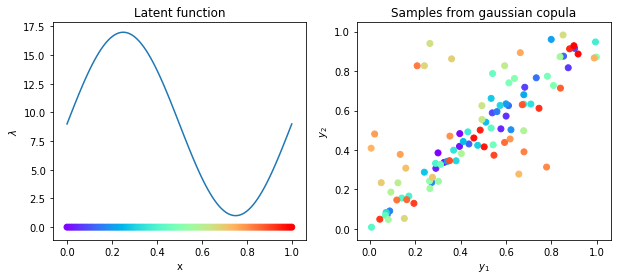

In [3]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = 1e2

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

# Y = np.zeros((NSamp,2))
# copula = GaussCopula()
# for i,x in enumerate(X):
#     if scale(x) == 0:
#         Y[i] = np.random.uniform(low=0,high=1,size=2)
#     else:
#         Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
scales = [scale(x) for x in X]
model = GumbelCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0, 1, NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from gaussian copula')

fig.show()

In [4]:
Y[Y == float("inf")]

array([], dtype=float32)

In [5]:
Y[Y == float('nan')]

array([], dtype=float32)

In [6]:
(np.min(Y),np.max(Y))

(0.0065437304, 0.99826837)

In [7]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [8]:
from gpytorch.lazy import CholLazyTensor
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational.variational_distribution import VariationalDistribution
from gpytorch.utils.deprecation import _deprecate_kwarg_with_transform
class CholeskyVariationalDistribution(gpytorch.variational.VariationalDistribution):
    """
    VariationalDistribution objects represent the variational distribution q(u) over a set of inducing points for GPs.
    The most common way this distribution is defined is to parameterize it in terms of a mean vector and a covariance
    matrix. In order to ensure that the covariance matrix remains positive definite, we only consider the lower triangle
    and we manually ensure that the diagonal remains positive.
    """

    def __init__(self, num_inducing_points, batch_shape=torch.Size([]), **kwargs):
        """
        Args:
            num_inducing_points (int): Size of the variational distribution. This implies that the variational mean
                should be this size, and the variational covariance matrix should have this many rows and columns.
            batch_shape (torch.Size, optional): Specifies an optional batch
                size for the variational parameters. This is useful for example
                when doing additive variational inference.
        """
        batch_shape = _deprecate_kwarg_with_transform(
            kwargs, "batch_size", "batch_shape", batch_shape, lambda n: torch.Size([n])
        )
        super(gpytorch.variational.VariationalDistribution, self).__init__()
        mean_init = torch.ones(num_inducing_points) * 1.4
        covar_init = torch.eye(num_inducing_points, num_inducing_points)
        mean_init = mean_init.repeat(*batch_shape, 1)
        covar_init = covar_init.repeat(*batch_shape, 1, 1)

        self.register_parameter(name="variational_mean", parameter=torch.nn.Parameter(mean_init))
        self.register_parameter(name="chol_variational_covar", parameter=torch.nn.Parameter(covar_init))

    def initialize_variational_distribution(self, prior_dist):
        self.variational_mean.data.copy_(prior_dist.mean)
        self.chol_variational_covar.data.copy_(prior_dist.scale_tril)

    @property
    def variational_distribution(self):
        """
        Return the variational distribution q(u) that this module represents.
        In this simplest case, this involves directly returning the variational mean. For the variational covariance
        matrix, we consider the lower triangle of the registered variational covariance parameter, while also ensuring
        that the diagonal remains positive.
        """
        chol_variational_covar = self.chol_variational_covar
        dtype = chol_variational_covar.dtype
        device = chol_variational_covar.device

        # First make the cholesky factor is upper triangular
        lower_mask = torch.ones(self.chol_variational_covar.shape[-2:], dtype=dtype, device=device).tril(0)
        chol_variational_covar = chol_variational_covar.mul(lower_mask)

        # Now construct the actual matrix
        variational_covar = CholLazyTensor(chol_variational_covar)
        return MultivariateNormal(self.variational_mean, variational_covar)

In [9]:
class KISS_GPInferenceModel2(gpytorch.models.PyroVariationalGP):
    def __init__(self, likelihood, prior_rbf_length=0.1, grid_size=128, grid_bounds=[(0, 1)], name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = CholeskyVariationalDistribution(grid_size)
        variational_strategy = gpytorch.variational.GridInterpolationVariationalStrategy(
            self, grid_size, grid_bounds, variational_distribution
        )
        
        # Standard initializtation
        super(KISS_GPInferenceModel2, self).__init__(variational_strategy, likelihood, num_data=grid_size) #?
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()#prior = gpytorch.priors.NormalPrior(14.,14.0))
        
        #we specify prior here
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [10]:
f=torch.tensor([1.4])
(torch.sigmoid(2.*f)-0.5)*34.0

tensor([15.0510])

In [11]:
# define the model (optionally on GPU)
grid_size = 128
#model = GPInferenceModel(train_x, train_y, GaussianCopula_Likelihood())#.cuda(device=0)
model = KISS_GPInferenceModel2(GumbelCopula_Likelihood(), prior_rbf_length=0.5, grid_size=grid_size).cuda(device=0)

In [ ]:
# train the model
from pyro import optim

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .05} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        #print(param_name)
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

def train(num_iter=2000):
    elbo = pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True, max_plate_nesting=1)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    p = 0.
    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy().copy())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p/np.abs(loss), np.mean(means[-1]), np.mean(np.abs(1-means[-100]/means[-1]))
            ))
            
            #print(np.std(losses[-100:]))
            if (0 < mean_p/np.abs(loss) < 0.01):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.
        
%time train()

Basic lr for most of parameters: 0.001


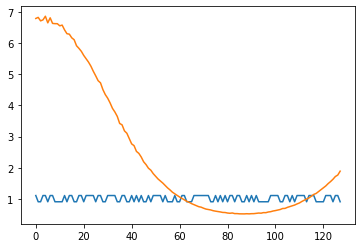

In [13]:
plt.plot(np.exp(means[0]))
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

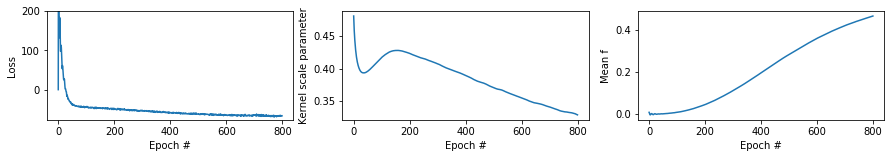

In [14]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(np.min(losses)*1.1,200)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [15]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

/home/nina/.envs/GPyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


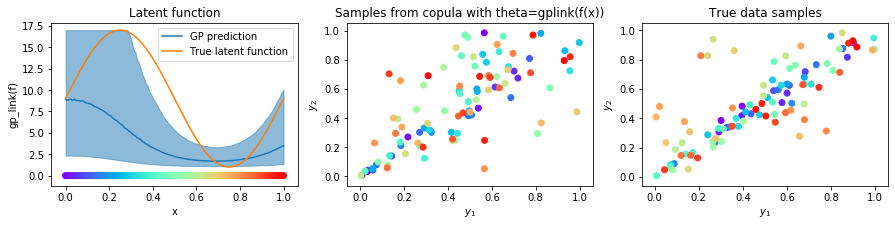

In [18]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
samples = output.rsample(torch.Size([2048]))
F_mean = gplink(samples).mean(0).detach().cpu().numpy()
#F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()

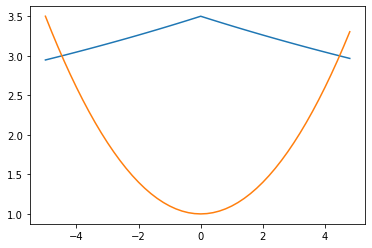

In [17]:
x = np.arange(-5,5,0.2)
plt.plot(x,(1.+2.5*np.exp(-np.abs(x)*0.05)))
plt.plot(x,1+0.1*x**2)